# general imports

In [1]:
from __future__ import division, print_function

import numpy as np
np.random.seed(42)

from scipy.constants import m_p, c, e

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [2]:
import sys
sys.path.append('/home/oeftiger/cern/git/PyHEADTAIL/PyHEADTAIL/')

# PyHEADTAIL imports

In [3]:
from PyHEADTAIL.particles.generators import RFBucketMatcher, StationaryExponential
from PyHEADTAIL.trackers.rf_bucket import RFBucket

PyHEADTAIL v1.10.5.276
(dirty git work tree)





In [4]:
rfb = RFBucket(100*2*np.pi, 2.5, m_p, e, [0.027], 0., [8], [24e3], [np.pi])

sigma_z = 180e-9*0.91*c/4.

# Helper Functions

In [5]:
def plot(stat_dist_class=StationaryExponential, rfb=rfb, sigma_z=sigma_z):
    '''Plot properties of stationary distribution class stat_dist_class
    for the given RF bucket and the bunch length (used for the guessed
    distribution Hamiltonian limit H0).
    Args:
        - stat_dist_class: Stationary Distribution class
          (e.g. generators.StationaryExponential)
        - rfb: RFBucket instance
        - sigma_z: bunch length to be matched
    '''
    stat_exp = stat_dist_class(lambda *args: rfb.hamiltonian(*args, make_convex=True))
    stat_exp.H0 = rfb.guess_H0(sigma_z, from_variable='sigma')

    dpmax = rfb.dp_max(rfb.z_ufp_separatrix)
    zz = np.linspace(*rfb.interval, num=1000)
    Z, DP = np.meshgrid(zz, np.linspace(-dpmax*1.1, dpmax*1.1, num=100))

    fig, ax = plt.subplots(2, 2, figsize=(12, 8))

    plt.sca(ax[0, 0])
    plt.title('phase space distribution', fontsize=20)
    plt.contourf(Z, DP, stat_exp.function(Z, DP), 20, cmap=cm.hot_r)
    plt.colorbar().set_label(r'$\psi(z, \delta)$', fontsize=20)
    plt.plot(zz, rfb.separatrix(zz), c='purple', lw=2)
    plt.plot(zz, -rfb.separatrix(zz), c='purple', lw=2)
    plt.xlabel(r'$z$', fontsize=20)
    plt.ylabel(r'$\delta$', fontsize=20)

    plt.sca(ax[0, 1])
    plt.title('Hamiltonian contours', fontsize=20)
    plt.contourf(Z, DP, stat_exp.H(Z, DP), 20, cmap=cm.coolwarm)
    plt.colorbar().set_label(r'$\mathcal{H}(z,\delta)$', fontsize=20)
    plt.plot(zz, rfb.separatrix(zz), c='purple', lw=2)
    plt.plot(zz, -rfb.separatrix(zz), c='purple', lw=2)
    plt.xlabel(r'$z$', fontsize=20)
    plt.ylabel(r'$\delta$', fontsize=20)

    plt.sca(ax[1, 0])
    plt.title('line density', fontsize=20)
    plt.plot(zz, np.sum(stat_exp.function(Z, DP), axis=0), antialiased=False)
    plt.xlabel(r'$z$', fontsize=20)
    plt.ylabel(r'$\lambda(z) = \int\; d\delta \; \psi(z, \delta)$', fontsize=20)

    plt.sca(ax[1, 1])
    plt.title('Hamiltonian distribution', fontsize=20)
    hhs = stat_exp.H(Z, DP).ravel()
    counts = stat_exp.function(Z, DP).ravel()
    perm = np.argsort(hhs)
    plt.plot(hhs[perm], counts[perm])
    plt.xlabel(r'$\mathcal{H}$', fontsize=20)
    plt.ylabel(r'$\psi(\mathcal{H})$', fontsize=20)
    plt.ylim(-0.1, 1.1)

    plt.tight_layout()
    
    return fig

# Thermal (Gaussian-like) Distribution 

In [6]:
class StationaryExponential(object):
    def __init__(self, H, Hmax=None, Hcut=0):
        self.H = H
        self.H0 = 1
        if not Hmax:
            self.Hmax = H(0, 0)
        else:
            self.Hmax = Hmax
        self.Hcut = Hcut

    def _psi(self, H):
        # convert from convex Hamiltonian
        # (SFP being the maximum and the separatrix having zero value)
        # to conventional scale (zero-valued minimum at SFP)
        Hsep = self.Hcut + self.Hmax
        Hn = Hsep - H
        # f(Hn) - f(Hsep)
        return np.exp(-Hn / self.H0) - np.exp(-(self.Hcut + self.Hmax) / self.H0)

    def function(self, z, dp):
        return self._psi(self.H(z, dp).clip(min=0)) / self._psi(self.Hmax)

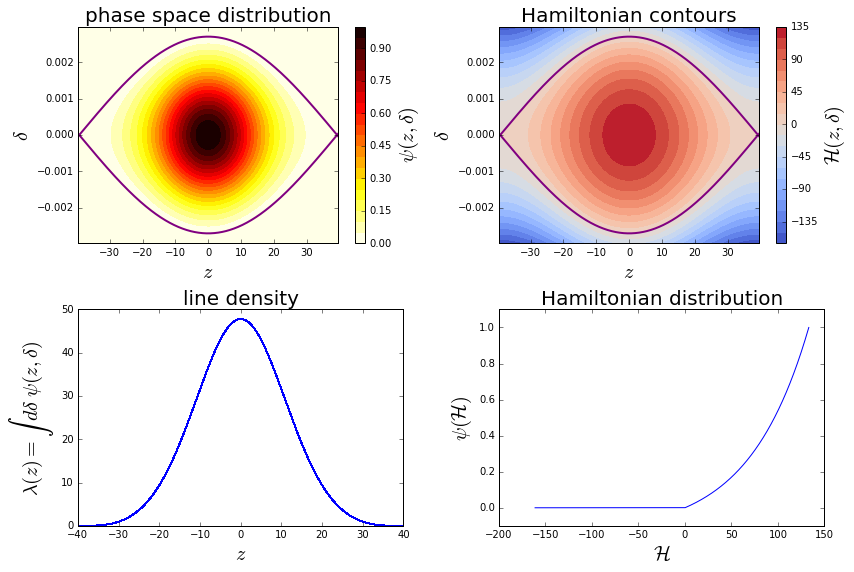

In [7]:
plot(StationaryExponential);

In [8]:
rfb_matcher = RFBucketMatcher(rfb, StationaryExponential, sigma_z=sigma_z)

z, dp, _, _ = rfb_matcher.generate(int(1e5))

*** Maximum RMS bunch length 12.3783736062m.
... distance to target bunch length: -1.4207e+00
... distance to target bunch length: -1.4203e+00
... distance to target bunch length: -6.0413e-01
... distance to target bunch length: -3.6092e-01
... distance to target bunch length: -1.8018e-01
... distance to target bunch length: -8.8324e-02
... distance to target bunch length: -3.6680e-02
... distance to target bunch length: -1.1805e-02
... distance to target bunch length: -2.2833e-03
... distance to target bunch length: -1.7779e-04
... distance to target bunch length: -2.9257e-06
... distance to target bunch length: -3.8184e-09
... distance to target bunch length: -8.8818e-14
--> Bunch length: 12.2765011551
--> Emittance: 1.1874973403


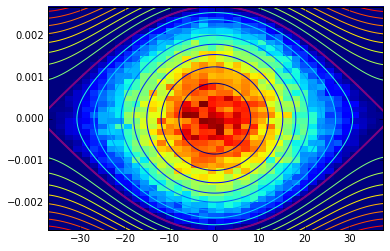

In [9]:
dpmax = rfb.dp_max(rfb.z_ufp_separatrix)
zz = np.linspace(*rfb.interval, num=1000)
Z, DP = np.meshgrid(zz, np.linspace(-dpmax*1.1, dpmax*1.1, num=100))
H = rfb.hamiltonian(Z, DP)
plt.contour(Z, DP, H, 20)
# plt.scatter(z, dp, alpha=0.6)
plt.hist2d(z, dp, bins=40)
plt.plot(zz, rfb.separatrix(zz), c='purple', lw=2)
plt.plot(zz, -rfb.separatrix(zz), c='purple', lw=2)

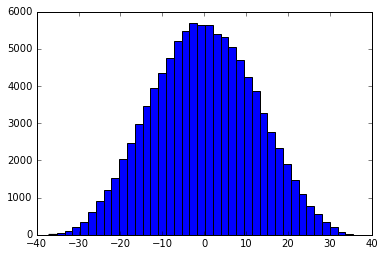

In [10]:
plt.hist(z, bins=40);

# Binomial Distribution

In [11]:
class StationaryBinomial(object):
    n = 2
    def __init__(self, H, Hmax=None, Hcut=0):
        self.H = H
        self.H0 = 1
        if not Hmax:
            self.Hmax = H(0, 0)
        else:
            self.Hmax = Hmax
        self.Hcut = Hcut

    def _psi(self, H):
        # convert from convex Hamiltonian
        # (SFP being the maximum and the separatrix having zero value)
        # to conventional scale (zero-valued minimum at SFP)
        Hsep = self.Hcut + self.Hmax
        Hn = Hsep - H
        return (1 - Hn / self.H0).clip(min=0)**self.n

    def function(self, z, dp):
        return self._psi(self.H(z, dp).clip(min=0)) / self._psi(self.Hmax)

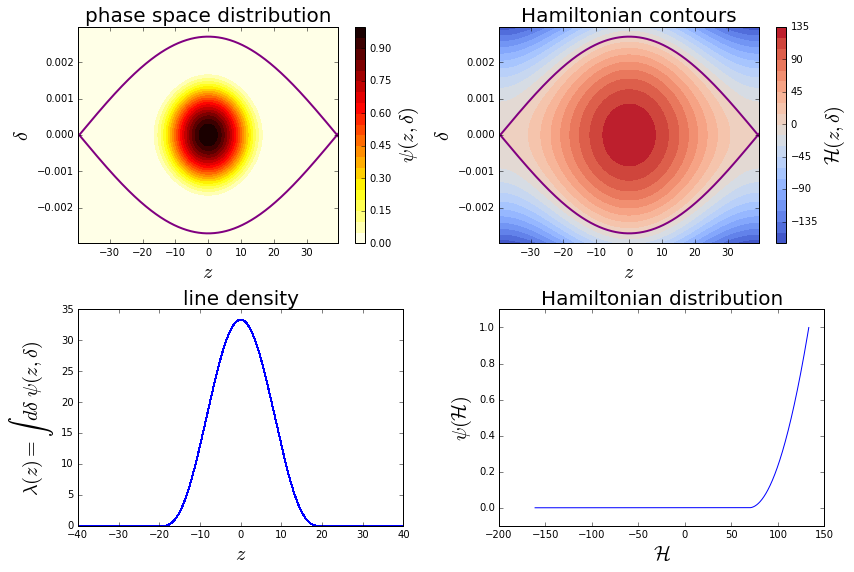

In [12]:
plot(StationaryBinomial);

In [13]:
rfb_matcher = RFBucketMatcher(rfb, StationaryBinomial, sigma_z=sigma_z)

z, dp, _, _ = rfb_matcher.generate(int(1e5))

*** Maximum RMS bunch length 17.0888244326m.
... distance to target bunch length: -5.8104e+00
... distance to target bunch length: -5.8097e+00
... distance to target bunch length: 1.1567e+00
... distance to target bunch length: 2.1880e-01
... distance to target bunch length: -4.7133e-02
... distance to target bunch length: 1.4259e-03
... distance to target bunch length: 8.8319e-06
... distance to target bunch length: -1.6732e-09
--> Bunch length: 12.2765011551
--> Emittance: 1.1650141082


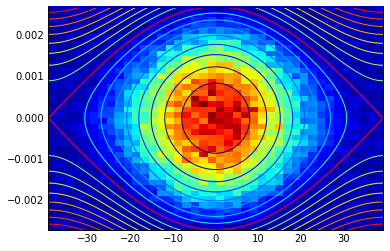

In [14]:
dpmax = rfb.dp_max(rfb.z_ufp_separatrix)
zz = np.linspace(*rfb.interval, num=1000)
Z, DP = np.meshgrid(zz, np.linspace(-dpmax*1.1, dpmax*1.1, num=100))
H = rfb.hamiltonian(Z, DP)
plt.contour(Z, DP, H, 20)
# plt.scatter(z, dp, alpha=0.6)
plt.hist2d(z, dp, bins=40)
plt.plot(zz, rfb.separatrix(zz), c='purple', lw=2)
plt.plot(zz, -rfb.separatrix(zz), c='purple', lw=2)

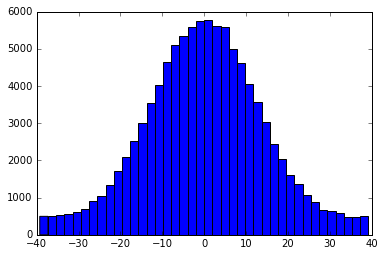

In [15]:
plt.hist(z, bins=40);

# Waterbag

In [16]:
class StationaryWaterbag(object):
    def __init__(self, H, Hmax=None, Hcut=0):
        self.H = H
        self.H0 = 1
        if not Hmax:
            self.Hmax = H(0, 0)
        else:
            self.Hmax = Hmax
        self.Hcut = Hcut

    def _psi(self, H):
        # convert from convex Hamiltonian
        # (SFP being the maximum and the separatrix having zero value)
        # to conventional scale (zero-valued minimum at SFP)
        Hsep = self.Hcut + self.Hmax
        Hn = Hsep - H
        return np.piecewise(Hn, [Hn <= self.H0, Hn > self.H0], [1./self.H0, 0])

    def function(self, z, dp):
        return self._psi(self.H(z, dp).clip(min=0)) / self._psi(self.Hmax)

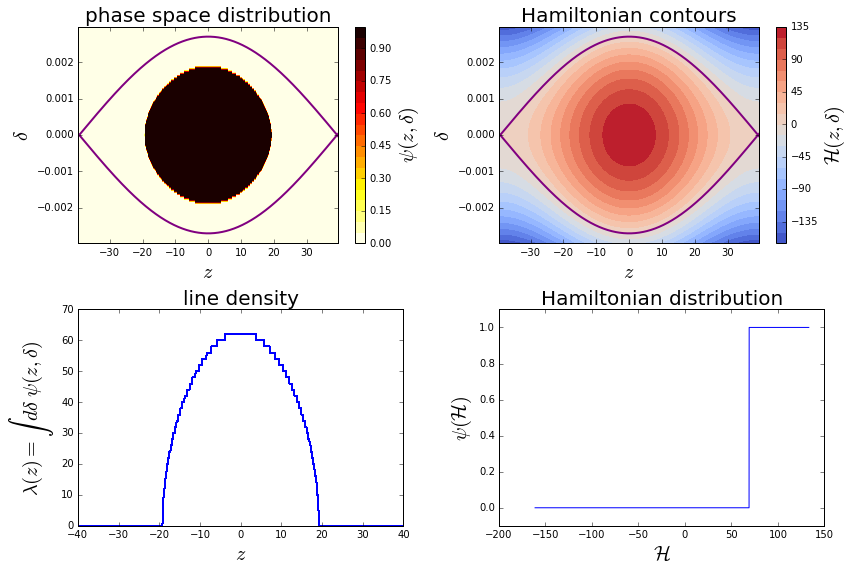

In [17]:
plot(StationaryWaterbag);

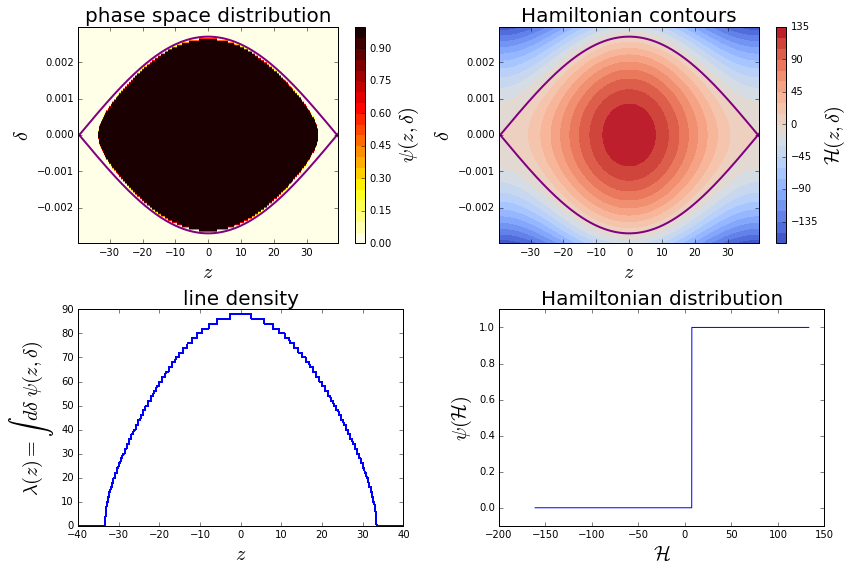

In [23]:
plot(StationaryWaterbag, sigma_z = 1.4*sigma_z);

In [24]:
rfb_matcher = RFBucketMatcher(rfb, StationaryWaterbag, sigma_z=sigma_z)

z, dp, _, _ = rfb_matcher.generate(int(1e5))

*** Maximum RMS bunch length 17.0916847522m.


KeyboardInterrupt: 

# Parabolic Bunch Shape

In [25]:
class StationaryParabolic(object):
    def __init__(self, H, Hmax=None, Hcut=0):
        self.H = H
        self.H0 = 1
        if not Hmax:
            self.Hmax = H(0, 0)
        else:
            self.Hmax = Hmax
        self.Hcut = Hcut

    def _psi(self, H):
        # convert from convex Hamiltonian
        # (SFP being the maximum and the separatrix having zero value)
        # to conventional scale (zero-valued minimum at SFP)
        Hsep = self.Hcut + self.Hmax
        Hn = Hsep - H
        return np.sqrt((1 - Hn / self.H0).clip(min=0))

    def function(self, z, dp):
        psi = self._psi(self.H(z, dp).clip(min=0))
#         return psi
        return psi / self._psi(self.Hmax)

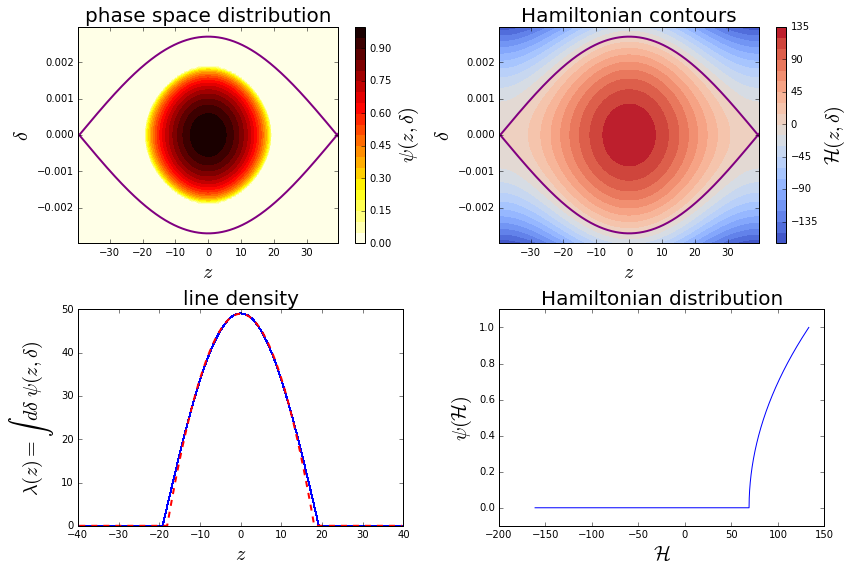

In [26]:
fig = plot(StationaryParabolic);
plt.sca(fig.axes[2])
plt.plot(zz, (49 - 0.15*zz**2).clip(min=0), color='red', lw=2, ls='--');

In [27]:
rfb_matcher = RFBucketMatcher(rfb, StationaryParabolic, sigma_z=sigma_z)

z, dp, _, _ = rfb_matcher.generate(int(1e5))

*** Maximum RMS bunch length 17.0909697093m.


/home/oeftiger/anaconda/lib/python2.7/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/home/oeftiger/anaconda/lib/python2.7/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


... distance to target bunch length: -3.9119e+00
... distance to target bunch length: -3.9108e+00


/home/oeftiger/anaconda/lib/python2.7/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


KeyboardInterrupt: 